In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [2]:
tf.__version__

'2.4.1'

In [3]:
filepath = '/content/timeseriesdata.csv'
df = pd.read_csv(filepath)
df

,Quarter,hdbrpi,labour-cost,gdp,population,cpi,exchange-rate,consumer-spending,overall unemployment,sti
0,1990 1Q,24.3,74.7,"16,669.50","2,647,627",61.907,1.8843,16.113111,31600,1458.400000
1,1990 2Q,24.4,70.5,"17,087.70","2,677,041",62.501,1.8396,16.999927,31600,1527.000000
2,1990 3Q,25.0,73.8,"17,930.10","2,706,454",63.181,1.7632,17.886744,31600,1098.700000
3,1990 4Q,24.7,84.9,"18,805","2,735,868",63.969,1.7445,18.773560,31600,1154.800000
4,1991 1Q,24.9,80.5,"18,521","2,750,577",64.249,1.7931,19.660376,31600,1490.800000
...,...,...,...,...,...,...,...,...,...,...
91,2012 4Q,146.7,98.3,"94,848.80","3,818,205",97.936,1.2221,113.643019,63500,3167.080078
92,2013 1Q,148.6,101.0,"93,773","3,824,842",98.574,1.2436,114.828898,65700,3308.100098
93,2013 2Q,149.4,88.5,"95,587.20","3,831,478",97.656,1.2652,115.705388,67900,3150.439941
94,2013 3Q,148.1,89.3,"96,028.30","3,838,115",98.865,1.2572,116.581878,63300,3167.870117


In [4]:
def todatetime(row):
    row['Quarter'] = row['Quarter'].replace(' 1Q', '-03')
    row['Quarter'] = row['Quarter'].replace(' 2Q', '-06')
    row['Quarter'] = row['Quarter'].replace(' 3Q', '-09')
    row['Quarter'] = row['Quarter'].replace(' 4Q', '-12')
    
    return row

df1 = df.apply(todatetime, axis='columns')
df1['Quarter'] = pd.to_datetime(df1['Quarter'], infer_datetime_format = True)

In [5]:
def tofloat(row):
    row['gdp'] = row['gdp'].replace(',', '')
    row['population'] = row['population'].replace(',', '')
    return row

df2 = df1.apply(tofloat, axis='columns')
df2['gdp'] = df2['gdp'].astype(float)
df2['population'] = df2['population'].astype(float)
df2['overall unemployment'] = df2['overall unemployment'].astype(float)
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Quarter               96 non-null     datetime64[ns]
 1   hdbrpi                96 non-null     float64       
 2   labour-cost           96 non-null     float64       
 3   gdp                   96 non-null     float64       
 4   population            96 non-null     float64       
 5   cpi                   96 non-null     float64       
 6   exchange-rate         96 non-null     float64       
 7   consumer-spending     96 non-null     float64       
 8   overall unemployment  96 non-null     float64       
 9   sti                   96 non-null     float64       
dtypes: datetime64[ns](1), float64(9)
memory usage: 7.6 KB


In [6]:
df3 = df2.drop(columns = 'Quarter')
df3

,hdbrpi,labour-cost,gdp,population,cpi,exchange-rate,consumer-spending,overall unemployment,sti
0,24.3,74.7,16669.5,2647627.0,61.907,1.8843,16.113111,31600.0,1458.400000
1,24.4,70.5,17087.7,2677041.0,62.501,1.8396,16.999927,31600.0,1527.000000
2,25.0,73.8,17930.1,2706454.0,63.181,1.7632,17.886744,31600.0,1098.700000
3,24.7,84.9,18805.0,2735868.0,63.969,1.7445,18.773560,31600.0,1154.800000
4,24.9,80.5,18521.0,2750577.0,64.249,1.7931,19.660376,31600.0,1490.800000
...,...,...,...,...,...,...,...,...,...
91,146.7,98.3,94848.8,3818205.0,97.936,1.2221,113.643019,63500.0,3167.080078
92,148.6,101.0,93773.0,3824842.0,98.574,1.2436,114.828898,65700.0,3308.100098
93,149.4,88.5,95587.2,3831478.0,97.656,1.2652,115.705388,67900.0,3150.439941
94,148.1,89.3,96028.3,3838115.0,98.865,1.2572,116.581878,63300.0,3167.870117


In [7]:
df4 = df3.hdbrpi
df4.shape

(96,)

In [8]:
data = df4.to_numpy()
data.shape

(96,)

In [9]:
num_features = 1
data = data.reshape((len(data), num_features))
data.shape

(96, 1)

In [10]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(data, data, test_size=0.2, random_state=0, shuffle=False)

In [33]:
win_length = 2
print(Xtrain.shape)
print(Xtest.shape)

(76, 1)
(20, 1)


In [34]:
train_generator = TimeseriesGenerator(Xtrain, Ytrain, length=win_length, sampling_rate=1, batch_size=96)
test_generator = TimeseriesGenerator(Xtest, Ytest, length=win_length, sampling_rate=1, batch_size=96)

In [35]:
X_train = train_generator[0][0]
Y_train = train_generator[0][1]
X_test = test_generator[0][0]
Y_test = test_generator[0][1]
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(74, 2, 1)
(74, 1)
(18, 2, 1)
(18, 1)


In [44]:
GRU_model = tf.keras.Sequential()
#GRU_model.add(tf.keras.layers.GRU(6, activation='relu', input_shape=(win_length, num_features), return_sequences=False))
GRU_model.add(tf.keras.layers.GRU(10, activation='relu', return_sequences=True))
GRU_model.add(tf.keras.layers.GRU(16, activation='relu', return_sequences=True))
GRU_model.add(tf.keras.layers.GRU(10, activation='relu', return_sequences=False))
#GRU_model.add(tf.keras.layers.BatchNormalization())
#GRU_model.add(tf.keras.layers.GRU(6, activation='relu', return_sequences=False))
GRU_model.add(tf.keras.layers.Dense(1))

In [45]:
GRU_model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics=[tf.metrics.MeanAbsoluteError()])
GRU_history = GRU_model.fit(X_train, Y_train, epochs=200, validation_data=(X_test, Y_test), batch_size=6)

Epoch 1/200
13/13 [==============================] - 4s 47ms/step - loss: 4671.5575 - mean_absolute_error: 64.6746 - val_loss: 10818.1260 - val_mean_absolute_error: 103.4457
Epoch 2/200
13/13 [==============================] - 0s 9ms/step - loss: 1905.1700 - mean_absolute_error: 38.0811 - val_loss: 356.2120 - val_mean_absolute_error: 18.3453
Epoch 3/200
13/13 [==============================] - 0s 8ms/step - loss: 121.1788 - mean_absolute_error: 8.8311 - val_loss: 209.9062 - val_mean_absolute_error: 14.3648
Epoch 4/200
13/13 [==============================] - 0s 8ms/step - loss: 40.4529 - mean_absolute_error: 5.1509 - val_loss: 7.1475 - val_mean_absolute_error: 2.1753
Epoch 5/200
13/13 [==============================] - 0s 8ms/step - loss: 31.9291 - mean_absolute_error: 4.1921 - val_loss: 12.0833 - val_mean_absolute_error: 3.1493
Epoch 6/200
13/13 [==============================] - 0s 8ms/step - loss: 21.1621 - mean_absolute_error: 3.5608 - val_loss: 44.5678 - val_mean_absolute_error: 6

In [46]:
print("train MSE", min(GRU_history.history['loss']))
print("val MSE", min(GRU_history.history['val_loss']))

train MSE 3.6571388244628906
val MSE 1.767086148262024


In [47]:
print("train MSE", GRU_history.history['loss'][-1])
print("val MSE", GRU_history.history['val_loss'][-1])

train MSE 6.035996437072754
val MSE 4.734809875488281


In [24]:
RNN_model = tf.keras.Sequential()
RNN_model.add(tf.keras.layers.SimpleRNN(16, activation='relu', input_shape=(win_length, num_features), return_sequences=True))
#RNN_model.add(tf.keras.layers.SimpleRNN(10, activation='relu', return_sequences=True))
#RNN_model.add(tf.keras.layers.SimpleRNN(16, activation='relu', return_sequences=True))
#RNN_model.add(tf.keras.layers.SimpleRNN(10, activation='relu', return_sequences=True))
#RNN_model.add(tf.keras.layers.BatchNormalization())
RNN_model.add(tf.keras.layers.SimpleRNN(16, activation='relu', return_sequences=False))
RNN_model.add(tf.keras.layers.Dense(1))

In [25]:
RNN_model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics=[tf.metrics.MeanAbsoluteError()])
RNN_history = RNN_model.fit(X_train, Y_train, epochs=200, validation_data=(X_test, Y_test), batch_size=6)

Epoch 1/200
12/12 [==============================] - 2s 49ms/step - loss: 2906.0828 - mean_absolute_error: 44.4510 - val_loss: 396.0586 - val_mean_absolute_error: 19.8105
Epoch 2/200
12/12 [==============================] - 0s 7ms/step - loss: 160.2277 - mean_absolute_error: 10.8222 - val_loss: 147.1963 - val_mean_absolute_error: 11.3398
Epoch 3/200
12/12 [==============================] - 0s 7ms/step - loss: 33.9951 - mean_absolute_error: 4.8354 - val_loss: 35.3546 - val_mean_absolute_error: 5.4989
Epoch 4/200
12/12 [==============================] - 0s 7ms/step - loss: 33.1443 - mean_absolute_error: 4.4313 - val_loss: 39.0766 - val_mean_absolute_error: 5.8036
Epoch 5/200
12/12 [==============================] - 0s 7ms/step - loss: 28.4809 - mean_absolute_error: 4.2464 - val_loss: 21.6051 - val_mean_absolute_error: 3.5692
Epoch 6/200
12/12 [==============================] - 0s 7ms/step - loss: 28.9563 - mean_absolute_error: 4.1220 - val_loss: 20.9193 - val_mean_absolute_error: 3.5346


In [26]:
print("train MSE", min(RNN_history.history['loss']))
print("val MSE", min(RNN_history.history['val_loss']))

train MSE 3.6786766052246094
val MSE 1.8974205255508423


In [27]:
print("train MSE", RNN_history.history['loss'][-1])
print("val MSE", RNN_history.history['val_loss'][-1])

train MSE 4.471568584442139
val MSE 18.332420349121094


In [28]:
def prepare_data(timeseries_data, n_features):
	X, y =[],[]
	for i in range(len(timeseries_data)):
		# find the end of this pattern
		end_ix = i + n_features
		# check if we are beyond the sequence
		if end_ix > len(timeseries_data)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = timeseries_data[i:end_ix], timeseries_data[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [29]:
X, Y = prepare_data(data, 5)

In [48]:
GRU_Y_pred = GRU_model.predict(X)
GRU_Y_pred.shape

(91, 1)

In [49]:
RNN_Y_pred = RNN_model.predict(X)
RNN_Y_pred.shape

(91, 1)

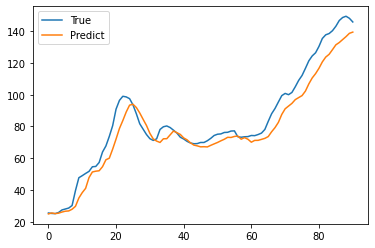

In [50]:
plt.plot(Y, label='True')
plt.plot(GRU_Y_pred,  label='Predict')
plt.legend()
plt.show()

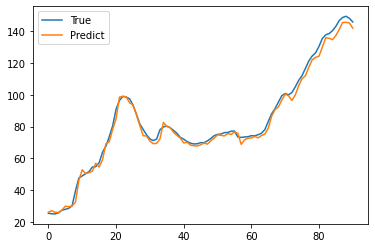

In [32]:
plt.plot(Y, label='True')
plt.plot(RNN_Y_pred,  label='Predict')
plt.legend()
plt.show()